In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from typing import *
from xgboost import XGBRegressor
plt.style.use('ggplot')


In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/TCP_LAB_4/'
TEST_PATH = '/content/drive/MyDrive/TCP_LAB_4/test.csv'

In [ ]:
df = pd.read_csv(TRAIN_PATH + 'train.csv')
display(df.head())
classes = df.columns
print('Names of classes', classes)
for col in df.columns:
    print(col, 'число уникальных значений в столбце: ', df[col].nunique())
    print(''.ljust(len(col)), 'тип столбца ', df[col].dtype, '\n')

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


Names of classes Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)'],
      dtype='object')
POSTED_BY число уникальных значений в столбце:  3
          тип столбца  object 

UNDER_CONSTRUCTION число уникальных значений в столбце:  2
                   тип столбца  int64 

RERA число уникальных значений в столбце:  2
     тип столбца  int64 

BHK_NO. число уникальных значений в столбце:  16
        тип столбца  int64 

BHK_OR_RK число уникальных значений в столбце:  2
          тип столбца  object 

SQUARE_FT число уникальных значений в столбце:  19561
          тип столбца  float64 

READY_TO_MOVE число уникальных значений в столбце:  2
              тип столбца  int64 

RESALE число уникальных значений в столбце:  2
       тип столбца  int64 

ADDRESS число уникальных значений в столбце:  6899
        тип столбца  object 

LONGITUDE число уникальных 

# Preproccessing

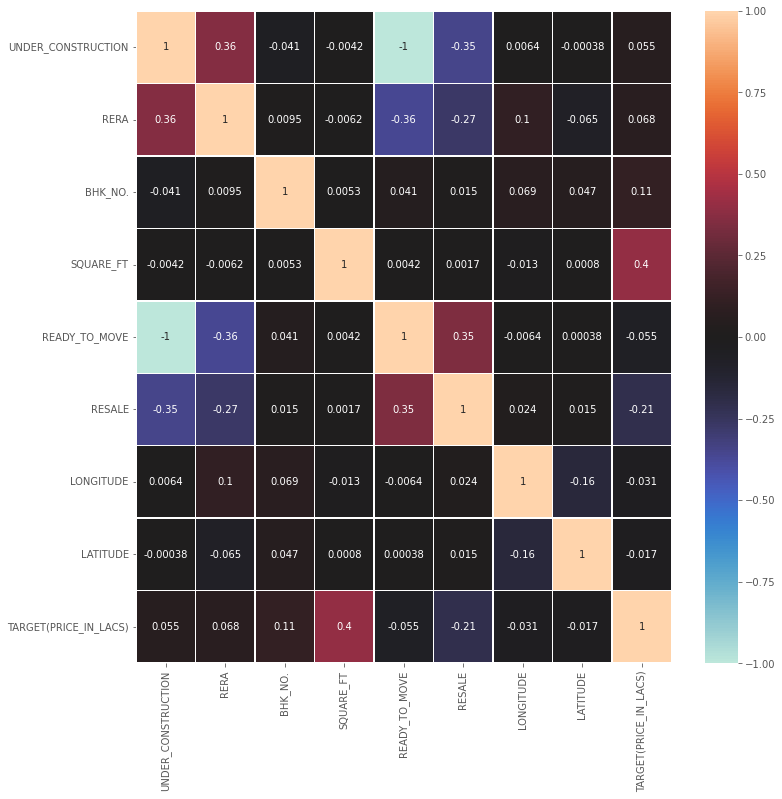

In [ ]:
plt.figure(figsize=(12, 12))
sns.heatmap(data=df.drop(columns='ADDRESS').corr(), annot=True, linewidths=.5, center=0)
plt.show()

In [ ]:
city = df['ADDRESS'].map(lambda x: x.split(',')[1].strip())
top80city = city.value_counts()[city.value_counts() > 1800].index.tolist()
city = city.map(lambda x: 'Other' if x not in top80city else x)
df['ADDRESS'] = city
print(city.unique())

['Bangalore' 'Other' 'Pune' 'Mumbai' 'Lalitpur']


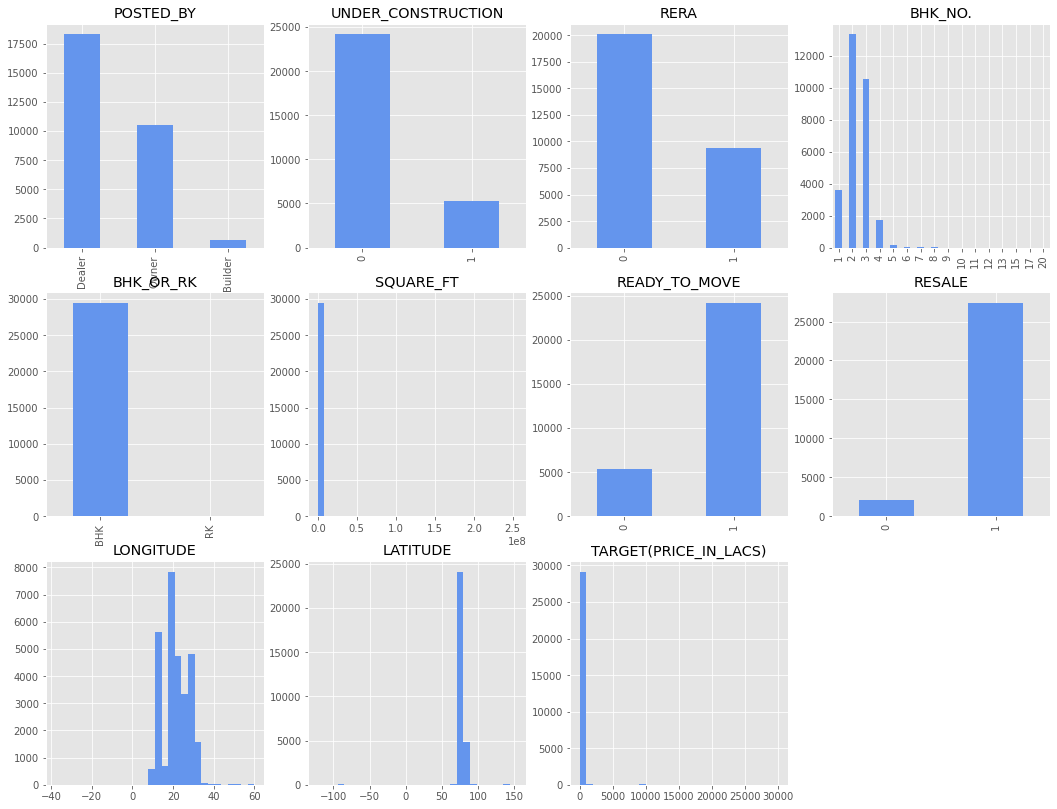

In [ ]:
plt.figure(figsize=(18, 14))
for i, col in enumerate(df.drop(columns='ADDRESS').columns):
    plt.subplot(3, 4, i+1)
    if df[col].dtype == 'object':
        df[col].value_counts().plot(kind='bar', color='cornflowerblue')
        plt.title(col)
    elif df[col].dtype != 'object' and df[col].nunique() <= 16:
        df[col].value_counts().sort_index().plot(kind='bar', color='cornflowerblue')
        plt.title(col)
    else:
        df[col].hist(bins=30, color='cornflowerblue')
        plt.title(col)

In [ ]:
print(df.shape)
df = df[df['TARGET(PRICE_IN_LACS)'] < 25000.]
df = df[df['TARGET(PRICE_IN_LACS)'] >= 1.]
print(df.shape)
df = df[df['SQUARE_FT'] < 3.400000e+05]
df = df[df['SQUARE_FT'] >= 10.]

print(df.shape)

df = df[df['LATITUDE'] > 50]
df = df[df['LATITUDE'] < 100]

print(df.shape)

df = df[df['LONGITUDE'] > 0]
df = df[df['LONGITUDE'] < 50]

print(df.shape)

df = df.drop(columns={'BHK_OR_RK'})
df = df.drop(columns={'UNDER_CONSTRUCTION', 'RESALE'})
print(df.shape)


(29451, 12)
(29444, 12)
(29435, 12)
(29178, 12)
(29178, 12)
(29178, 9)


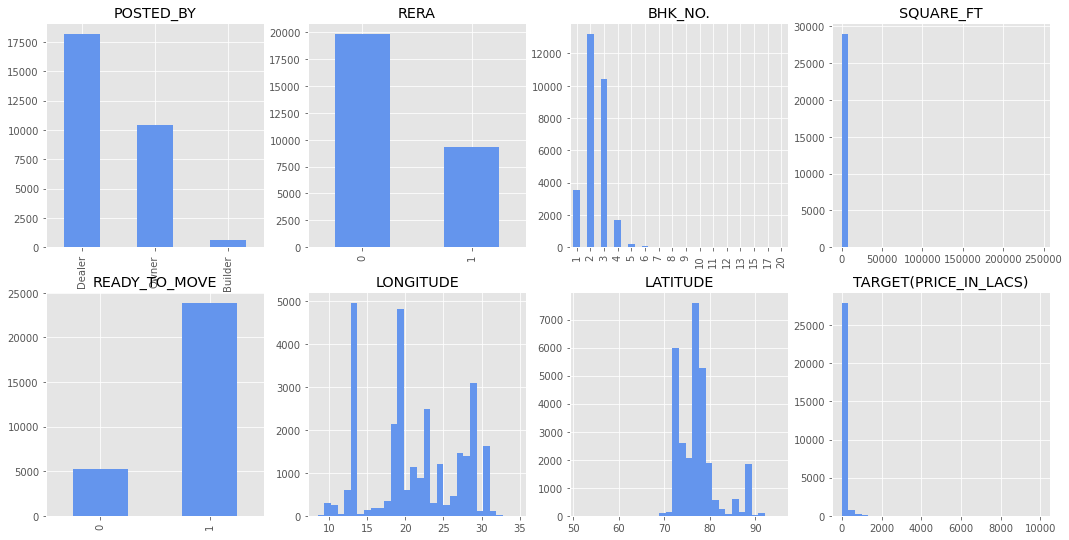

In [ ]:
plt.figure(figsize=(18, 14))
for i, col in enumerate(df.drop(columns='ADDRESS').columns):
    plt.subplot(3, 4, i+1)
    if df[col].dtype == 'object':
        df[col].value_counts().plot(kind='bar', color='cornflowerblue')
        plt.title(col)
    elif df[col].dtype != 'object' and df[col].nunique() <= 16:
        df[col].value_counts().sort_index().plot(kind='bar', color='cornflowerblue')
        plt.title(col)
    else:
        df[col].hist(bins=30, color='cornflowerblue')
        plt.title(col)

#Без категориальных признаков

In [ ]:
categorical = {'ADDRESS', 'POSTED_BY', 'RERA','READY_TO_MOVE','BHK_NO.'}#, 'RESALE'}

df_without_categorical = df.drop(columns=categorical)
X = df_without_categorical.drop(columns={'TARGET(PRICE_IN_LACS)'})
y = pd.Series(df['TARGET(PRICE_IN_LACS)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.head()

,SQUARE_FT,LONGITUDE,LATITUDE
19932,1210.025929,26.918680,75.750399
13016,1172.180255,26.900926,75.775927
4152,678.070581,13.055985,77.622157
28847,1589.303734,12.973237,77.646859
7561,1241.254796,12.870600,77.627900


In [ ]:
print(X_train.shape)
print(y_train.shape)

(23342, 3)
(23342,)


In [ ]:
lm_regressor = LinearRegression()
lm_regressor.fit(X_train, y_train)

LinearRegression()

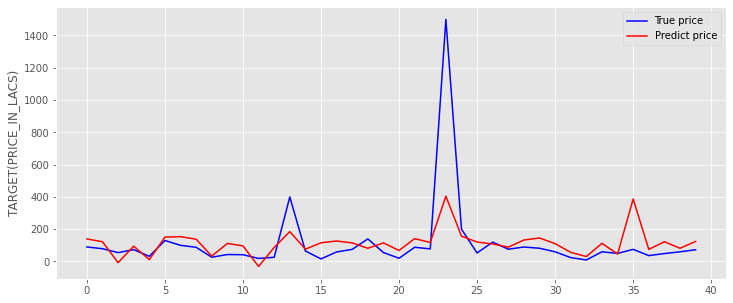

In [ ]:
plt.figure(figsize=(12, 5))
xax = np.array(list(range(40)), dtype=np.int64)
sns.lineplot(x=xax, y=y_test[:40], color='blue')
first_lm = lm_regressor.predict(X_test)[:40]
sns.lineplot(x=xax, y=first_lm, color='red')
plt.legend(['True price', 'Predict price'])
plt.show()

In [ ]:
xg_regressor = XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.3)
xg_regressor.fit(X_train, y_train)

[04:51:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=50)

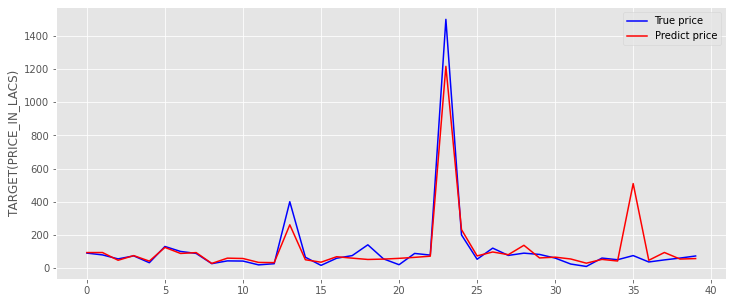

In [ ]:
plt.figure(figsize=(12, 5))
xax = np.array(list(range(40)), dtype=np.int64)
sns.lineplot(x=xax, y=y_test[:40], color='blue')
first_xg = xg_regressor.predict(X_test)[:40]
sns.lineplot(x=xax, y=first_xg, color='red')
plt.legend(['True price', 'Predict price'])
plt.show()

#С категориальными признаками one hot

In [ ]:
#df1 = df.drop(columns={'ADDRESS'})
categorical = {'ADDRESS', 'POSTED_BY', 'RERA','READY_TO_MOVE'}#, 'RESALE'}

df2 = pd.get_dummies(df, columns=categorical, drop_first=True)

In [ ]:
X = df2.drop(columns={'TARGET(PRICE_IN_LACS)'})
y = pd.Series(df2['TARGET(PRICE_IN_LACS)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.head()

,BHK_NO.,SQUARE_FT,LONGITUDE,LATITUDE,POSTED_BY_Dealer,POSTED_BY_Owner,RERA_1,READY_TO_MOVE_1,ADDRESS_Lalitpur,ADDRESS_Mumbai,ADDRESS_Other,ADDRESS_Pune
19932,2,1210.025929,26.918680,75.750399,0,1,0,1,0,0,1,0
13016,2,1172.180255,26.900926,75.775927,0,1,0,1,0,0,1,0
4152,1,678.070581,13.055985,77.622157,1,0,1,0,0,0,0,0
28847,3,1589.303734,12.973237,77.646859,1,0,0,1,0,0,1,0
7561,2,1241.254796,12.870600,77.627900,1,0,0,1,0,0,0,0


In [ ]:
lm_regressor = LinearRegression()
lm_regressor.fit(X_train, y_train)

LinearRegression()

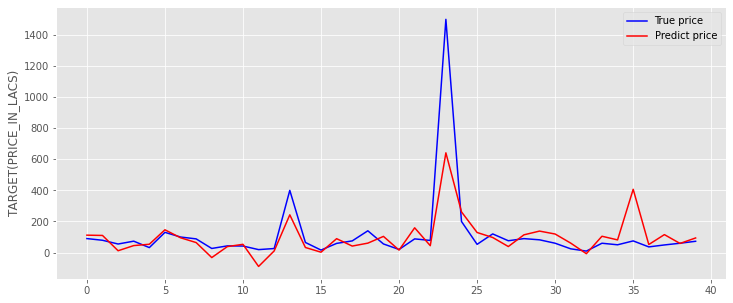

In [ ]:
plt.figure(figsize=(12, 5))
xax = np.array(list(range(40)), dtype=np.int64)
sns.lineplot(x=xax, y=y_test[:40], color='blue')
second_lm = lm_regressor.predict(X_test)[:40]
sns.lineplot(x=xax, y=second_lm, color='red')
plt.legend(['True price', 'Predict price'])
plt.show()

In [ ]:
lm_regressor = LinearRegression()
lm_regressor.fit(X_train, y_train)

RMSEtrain = mean_squared_error(y_train, lm_regressor.predict(X_train), squared=False)
RMSEtest = mean_squared_error(y_test, lm_regressor.predict(X_test), squared=False)
RMSEexptrain = mean_squared_error(y_train, lm_regressor.predict(X_train), squared=False)
RMSEexptest = mean_squared_error(y_test, lm_regressor.predict(X_test), squared=False)
R2test = lm_regressor.score(X_test, y_test)
R2train = lm_regressor.score(X_train, y_train)

print("Результаты линейной регрессии")
print(f"RMSE (log price)  train  {RMSEtrain:.4} test {RMSEtest:.4}")
print(f"RMSE (real price) train {RMSEexptrain:.4} test {RMSEexptest:.4}")
print(f"R2 (log price))   train {R2train:.4} test {R2test:.4}")

Результаты линейной регрессии
RMSE (log price)  train  319.0 test 314.7
RMSE (real price) train 319.0 test 314.7
R2 (log price))   train 0.6968 test 0.7762


In [ ]:
lm_coef_name = ['intercept'] + X_train.columns.tolist()
lm_coef = pd.DataFrame([[lm_regressor.intercept_] + lm_regressor.coef_.tolist()], columns=lm_coef_name)
lm_coef

,intercept,BHK_NO.,SQUARE_FT,LONGITUDE,LATITUDE,POSTED_BY_Dealer,POSTED_BY_Owner,RERA_1,READY_TO_MOVE_1,ADDRESS_Lalitpur,ADDRESS_Mumbai,ADDRESS_Other,ADDRESS_Pune
0,291.923916,38.749899,0.060312,-4.752919,-4.383123,44.133482,14.131379,20.67836,-7.286494,158.730125,170.532347,34.359985,30.844498


In [ ]:
print(lm_regressor.predict(X_test)[:40])

[111.929929   110.11278106  11.75982384  44.8419644   53.51414237
 146.40133314  95.19703758  64.37354981 -32.19936384  38.52117355
  52.98324298 -89.27564637  10.62232164 242.6299964   32.62786575
   2.40995491  89.36129432  41.79713729  60.6210609  104.0013812
  16.03843653 159.16818341  44.28542074 641.49414785 261.73344987
 129.0804955   96.92591164  38.78079046 114.02069577 138.14170028
 119.22316957  60.57350337  -7.19974421 104.97271867  81.46529547
 406.92584955  51.66192187 115.45715698  58.68856166  93.90653309]


In [ ]:
xg_regressor = XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.3)
xg_regressor.fit(X_train, y_train)

[04:51:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=50)

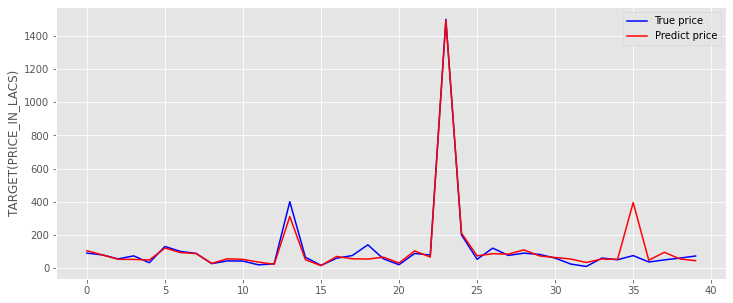

In [ ]:
plt.figure(figsize=(12, 5))
xax = np.array(list(range(40)), dtype=np.int64)
sns.lineplot(x=xax, y=y_test[:40], color='blue')
second_xg = xg_regressor.predict(X_test)[:40]
sns.lineplot(x=xax, y=second_xg, color='red')
plt.legend(['True price', 'Predict price'])
plt.show()

#С категориальными target encoding

In [ ]:
!pip install category_encoders
from category_encoders import TargetEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
encoder = TargetEncoder()
for cat in categorical:
  df[cat +  '_encoded'] = encoder.fit_transform(df[cat], df['TARGET(PRICE_IN_LACS)'])
  df = df.drop(columns={cat})
df

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


,BHK_NO.,SQUARE_FT,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),POSTED_BY_encoded,RERA_encoded,READY_TO_MOVE_encoded,ADDRESS_encoded
0,2,1300.236407,12.969910,77.597960,55.0,55.613979,0,1,145.185030
1,2,1275.000000,12.274538,76.644605,51.0,185.483766,0,1,107.971926
2,2,933.159722,12.778033,77.632191,43.0,55.613979,0,1,145.185030
3,2,929.921143,28.642300,77.344500,62.5,55.613979,1,1,107.971926
4,2,999.009247,22.592200,88.484911,60.5,185.483766,0,0,107.971926
...,...,...,...,...,...,...,...,...,...
29445,2,1062.134891,15.866670,74.500000,40.0,55.613979,0,1,107.971926
29446,3,2500.000000,27.140626,78.043277,45.0,55.613979,0,1,107.971926
29448,2,1022.641509,26.928785,75.828002,27.1,185.483766,0,1,107.971926
29449,2,927.079009,12.900150,80.227910,67.0,55.613979,0,1,107.971926


In [ ]:
X = df.drop(columns={'TARGET(PRICE_IN_LACS)'})
y = pd.Series(df['TARGET(PRICE_IN_LACS)'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.head()

,BHK_NO.,SQUARE_FT,LONGITUDE,LATITUDE,POSTED_BY_encoded,RERA_encoded,READY_TO_MOVE_encoded,ADDRESS_encoded
19932,2,1210.025929,26.918680,75.750399,55.613979,0,1,107.971926
13016,2,1172.180255,26.900926,75.775927,55.613979,0,1,107.971926
4152,1,678.070581,13.055985,77.622157,185.483766,1,0,145.185030
28847,3,1589.303734,12.973237,77.646859,185.483766,0,1,107.971926
7561,2,1241.254796,12.870600,77.627900,185.483766,0,1,145.185030


In [ ]:
lm_regressor = LinearRegression()
lm_regressor.fit(X_train, y_train)


LinearRegression()

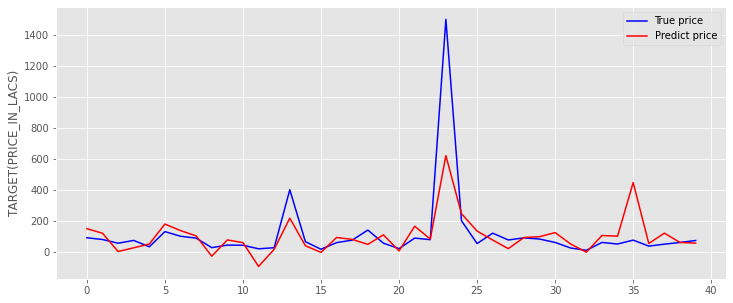

In [ ]:
plt.figure(figsize=(12, 5))
xax = np.array(list(range(40)), dtype=np.int64)
sns.lineplot(x=xax, y=y_test[:40], color='blue')
third_lm = lm_regressor.predict(X_test)[:40]
sns.lineplot(x=xax, y=third_lm, color='red')
plt.legend(['True price', 'Predict price'])
plt.show()

In [ ]:
xg_regressor = XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.3)
xg_regressor.fit(X_train, y_train)

[04:51:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.3, max_depth=5, n_estimators=50)

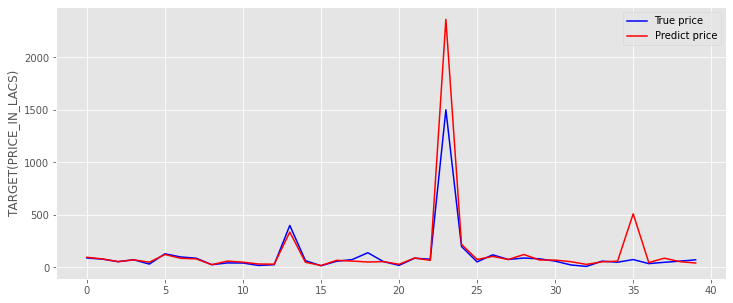

In [ ]:
plt.figure(figsize=(12, 5))
xax = np.array(list(range(40)), dtype=np.int64)
sns.lineplot(x=xax, y=y_test[:40], color='blue')
third_xg = xg_regressor.predict(X_test)[:40]
sns.lineplot(x=xax, y=third_xg, color='red')
plt.legend(['True price', 'Predict price'])
plt.show()

# Результаты

LINEAR MODEL


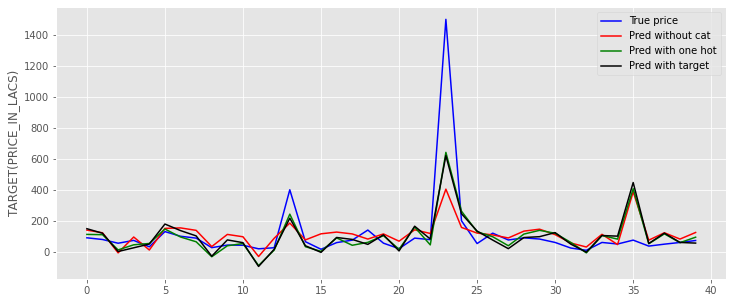

In [ ]:
plt.figure(figsize=(12, 5))

print('LINEAR MODEL')
sns.lineplot(x=xax, y=y_test[:40], color='blue')
sns.lineplot(x=xax, y=first_lm, color='red')
sns.lineplot(x=xax, y=second_lm, color='green')
sns.lineplot(x=xax, y=third_lm, color='black')
plt.legend(['True price', 'Pred without cat', 'Pred with one hot', 'Pred with target'])
plt.show()

XGBOOST


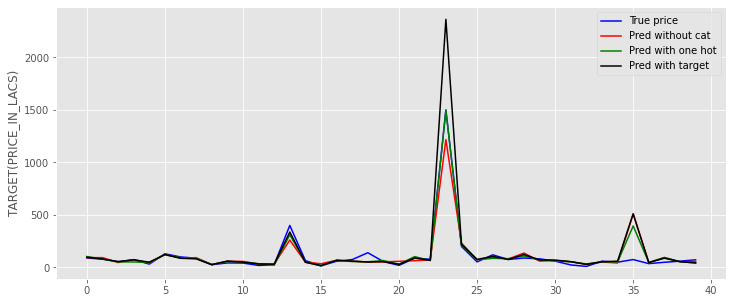

In [ ]:
plt.figure(figsize=(12, 5))

print('XGBOOST')
sns.lineplot(x=xax, y=y_test[:40], color='blue')
sns.lineplot(x=xax, y=first_xg, color='red')
sns.lineplot(x=xax, y=second_xg, color='green')
sns.lineplot(x=xax, y=third_xg, color='black')
plt.legend(['True price', 'Pred without cat', 'Pred with one hot', 'Pred with target'])
plt.show()

# Визуализация в пространстве главных компонент

In [ ]:
from sklearn.decomposition import PCA


In [ ]:
df['SQUARE_FT_log'] = np.log(df['SQUARE_FT'])
df['price_log'] = np.log(df['TARGET(PRICE_IN_LACS)'])
df = df[['SQUARE_FT_log', 'LONGITUDE', 'LATITUDE', 'TARGET(PRICE_IN_LACS)']].copy()

In [ ]:
PCA_dec = PCA(n_components=2, svd_solver='full')
df_pca = PCA_dec.fit_transform(X=df)
df_pca = pd.DataFrame(df_pca, columns=['x', "y"])

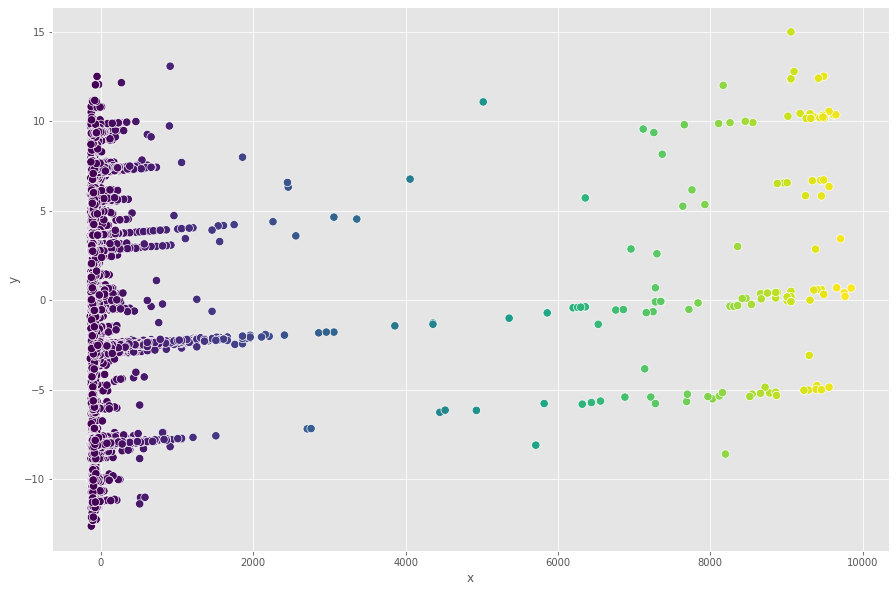

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x='x', y='y', data=df_pca, c=df['TARGET(PRICE_IN_LACS)'], s=70)
plt.show()